In [56]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


This dataset contains 433 images with bounding box annotations of the car license plates within the image. Our goal here is to train a convolutional neural network capable of locating licenses plate on new images.

## Preparation of the data

In [57]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

Import libraries

In [58]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

We display the files in Kaggle repertoire :

In [ ]:
# Dataset
# https://drive.google.com/file/d/1EIAZRIKGfkr3c5UVzO6nTLDFS1FoGzyE/view?usp=sharing

import os
import zipfile

zip_path = '/content/drive/MyDrive/Colab Notebooks/car-plate-detection.zip'

extracted_path = '/content/drive/MyDrive/Colab Notebooks/car-plate-detection'

if not os.listdir(extracted_path):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extracted_path)
else:
    print(f'Тека "{extracted_path}" містить {os.listdir(extracted_path)}')

In [59]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/car-plate-detection'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Colab Notebooks/car-plate-detection/annotations/Cars0.xml
/content/drive/MyDrive/Colab Notebooks/car-plate-detection/annotations/Cars1.xml
/content/drive/MyDrive/Colab Notebooks/car-plate-detection/annotations/Cars10.xml
/content/drive/MyDrive/Colab Notebooks/car-plate-detection/annotations/Cars100.xml
/content/drive/MyDrive/Colab Notebooks/car-plate-detection/annotations/Cars101.xml
/content/drive/MyDrive/Colab Notebooks/car-plate-detection/annotations/Cars102.xml
/content/drive/MyDrive/Colab Notebooks/car-plate-detection/annotations/Cars103.xml
/content/drive/MyDrive/Colab Notebooks/car-plate-detection/annotations/Cars104.xml
/content/drive/MyDrive/Colab Notebooks/car-plate-detection/annotations/Cars105.xml
/content/drive/MyDrive/Colab Notebooks/car-plate-detection/annotations/Cars106.xml
/content/drive/MyDrive/Colab Notebooks/car-plate-detection/annotations/Cars107.xml
/content/drive/MyDrive/Colab Notebooks/car-plate-detection/annotations/Cars108.xml
/content/

We create the variable X containing all the images of cars by resizing them.



In [60]:
IMAGE_SIZE = 224

In [61]:
img_dir = "/content/drive/MyDrive/Colab Notebooks/car-plate-detection/images" # Enter Directory of all images
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))


We create the variable y containing all the bounding boxe annotations (label).
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that.

In [62]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]


In [63]:
path = '/content/drive/MyDrive/Colab Notebooks/car-plate-detection/annotations'
text_files = ['/content/drive/MyDrive/Colab Notebooks/car-plate-detection/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [64]:
resizeannotation("/content/drive/MyDrive/Colab Notebooks/car-plate-detection/annotations/Cars147.xml")

[188, 141, 101, 104]

In [65]:
y[0]

[187, 144, 101, 104]

We check X et y shape

In [66]:
np.array(X).shape

(433, 224, 224, 3)

In [67]:
np.array(y).shape

(433, 4)

And we display the first eighteen image of the dataset :

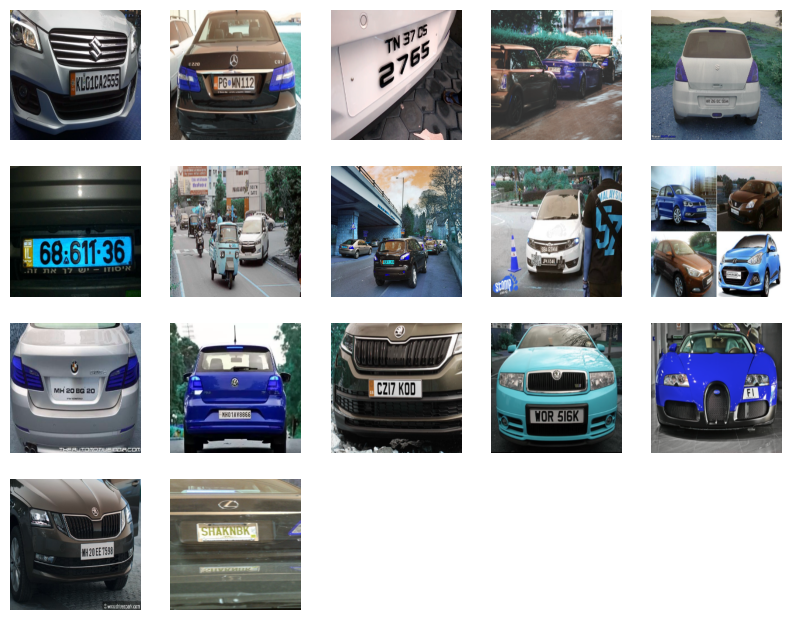

In [68]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

We can draw the rectangle containing the license plate using the OpenCV library

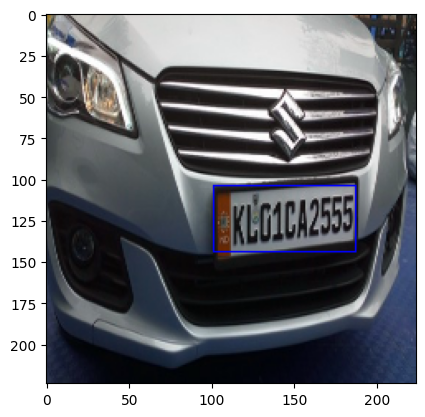

In [69]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


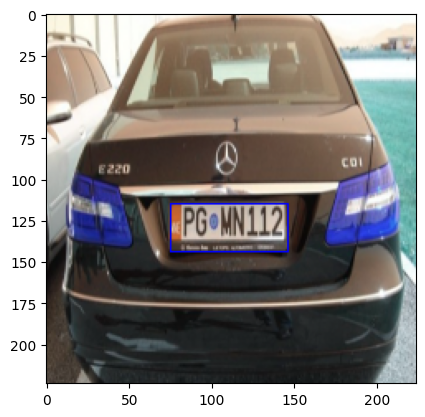

In [70]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


We prepare the data for the CNN :

In [71]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [72]:
#Renormalisation
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

In [74]:
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

from keras.applications.vgg16 import VGG16

In [75]:
# Create the model
model = Sequential()
#model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
#model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.2))
#model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.2))
#model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               3211392   
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                                 
Total params: 17951108 (68.48 MB)
Trainable params: 32

In [76]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

model.compile(loss='mean_squared_error',
              optimizer='adam',
              #optimizer=optimizer,
              metrics=['accuracy'])

In [77]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
10/10 [==============================] - 3s 192ms/step - loss: 0.0747 - accuracy: 0.5241 - val_loss: 0.0383 - val_accuracy: 0.6857
Epoch 2/50
10/10 [==============================] - 2s 162ms/step - loss: 0.0196 - accuracy: 0.6752 - val_loss: 0.0197 - val_accuracy: 0.7429
Epoch 3/50
10/10 [==============================] - 2s 165ms/step - loss: 0.0092 - accuracy: 0.7428 - val_loss: 0.0184 - val_accuracy: 0.6286
Epoch 4/50
10/10 [==============================] - 1s 149ms/step - loss: 0.0047 - accuracy: 0.8199 - val_loss: 0.0158 - val_accuracy: 0.6857
Epoch 5/50
10/10 [==============================] - 1s 147ms/step - loss: 0.0026 - accuracy: 0.8810 - val_loss: 0.0154 - val_accuracy: 0.7429
Epoch 6/50
10/10 [==============================] - 2s 153ms/step - loss: 0.0015 - accuracy: 0.8971 - val_loss: 0.0150 - val_accuracy: 0.6286
Epoch 7/50
10/10 [==============================] - 1s 152ms/step - loss: 0.0011 - accuracy: 0.9035 - val_loss: 0.0147 - val_accuracy: 0.7429
Epoch 

In [78]:
model.save('/content/drive/MyDrive/Colab Notebooks/my_model_vgg16.keras', overwrite=True)

In [79]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 87.36%


In [80]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

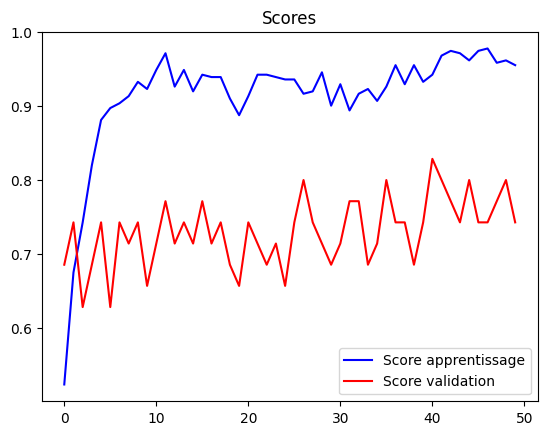

In [81]:
plot_scores(train)

## DETECTION

In [82]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)


 82/100 [=======================>......] - ETA: 0s - loss: 0.0064 - accuracy: 0.8780

100/100 [==============================] - 1s 9ms/step - loss: 0.0062 - accuracy: 0.8736
Test results 
 Loss: 0.006178568117320538 
 Accuracy 0.8735632300376892


In [83]:
 y_cnn = model.predict(X_test)

3/3 [==============================] - 0s 118ms/step


We can see how our model localize license plates on our testing set :

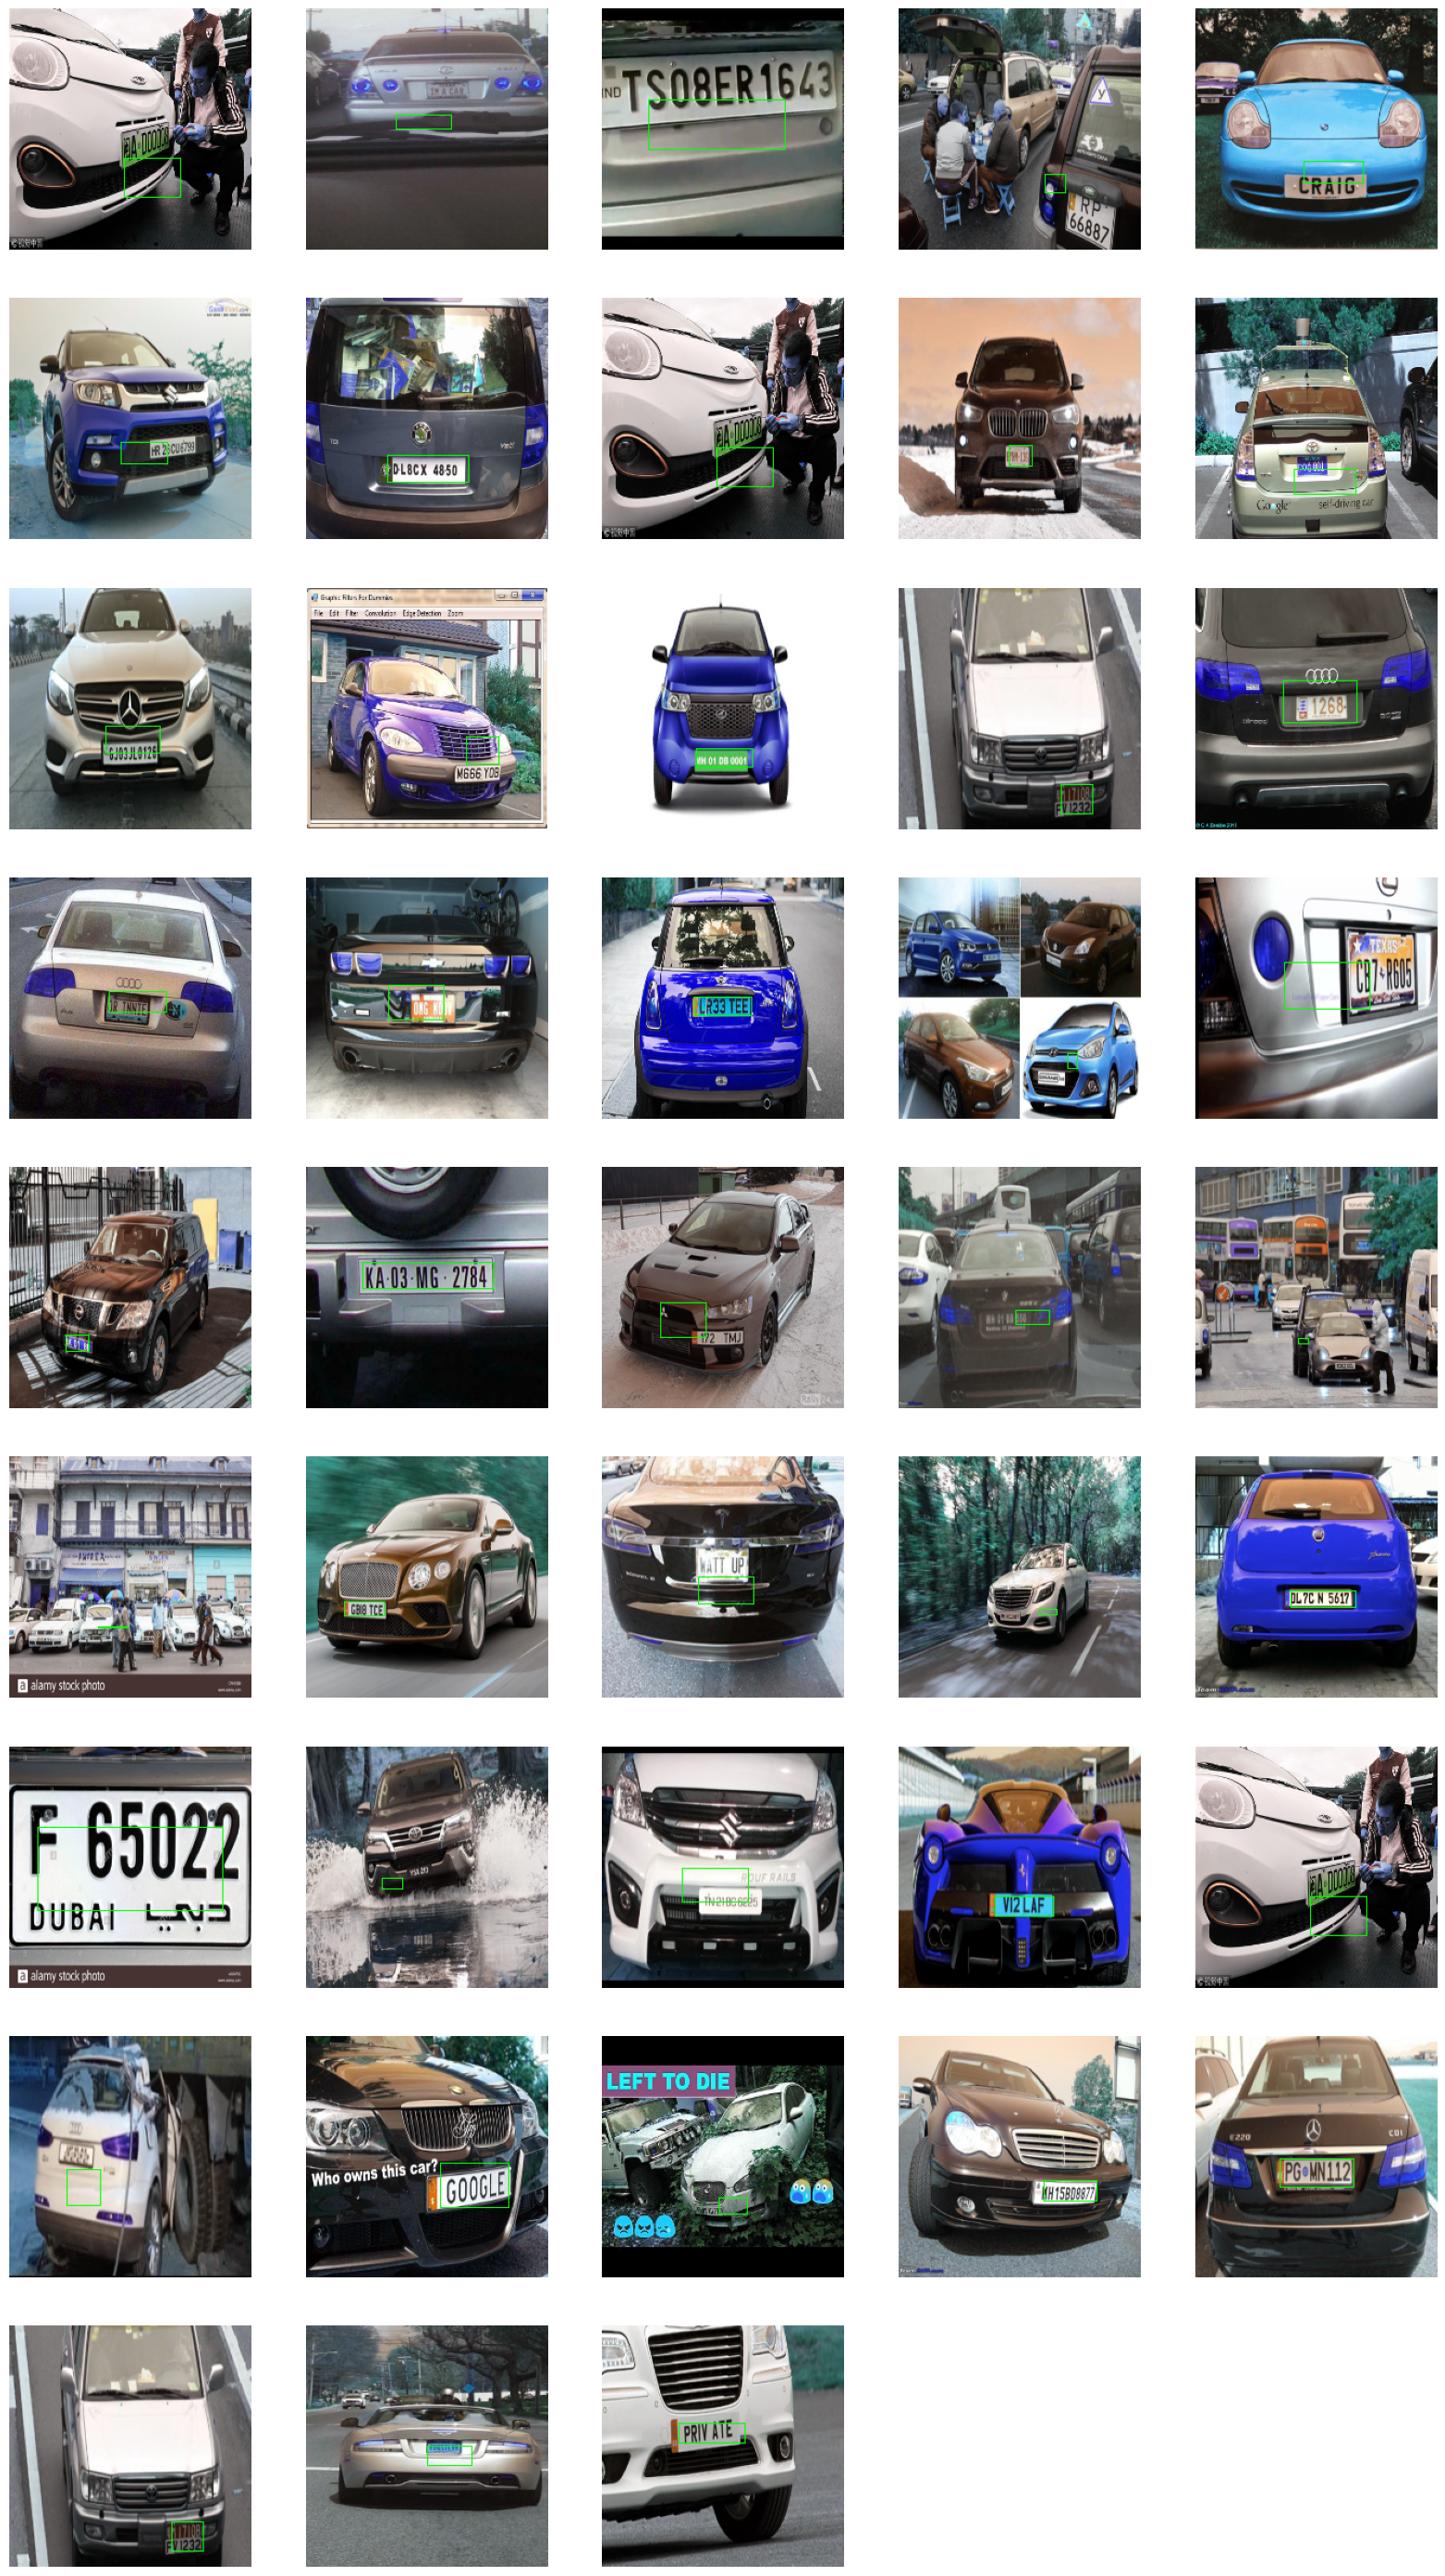

In [84]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)



In [85]:
%matplotlib inline

from matplotlib import pyplot as plt
import cv2
import numpy as np
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/my_model_84.keras')

In [86]:
#from google.colab import drive
#drive.mount('/content/drive/')

1/1 [==============================] - 0s 166ms/step


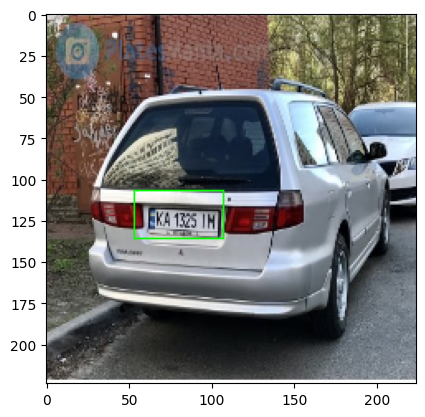

In [87]:

img_file = "/content/drive/MyDrive/Colab Notebooks/Car3400.png"
#img_file = "/content/drive/MyDrive/Colab Notebooks/car-plate-detection/images/Cars1.png"
IMAGE_SIZE = 224

img = cv2.imread(img_file)
img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
img = img.astype(np.float32) / 255.0
img = np.expand_dims(img, axis=0)  # Додавання першого розміру для створення батча зображень

# Подача зображення на вхід моделі та отримання результату
result = model.predict(img)

img = cv2.imread(img_file)
img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ny = result[0]*255
image = cv2.rectangle(img,(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
plt.imshow(image)